In [0]:
dbutils.fs.rm("/tmp/delta/sales_data", recurse=True)
dbutils.fs.rm("/tmp/checkpoints/sales_data", recurse=True)

False

In [0]:
from pyspark.sql import SparkSession
from IPython.display import clear_output

spark = SparkSession.builder.appName("SalesDataDisplay").getOrCreate()

json_file_path = "dbfs:/FileStore/sales_data/sample_sales.json"
delta_table_path = "dbfs:/FileStore/sales_data/delta_table"

df = spark.read.json(json_file_path)
df.write.format("delta").mode("overwrite").save(delta_table_path)

while True:
    df = spark.read.format("delta").load(delta_table_path)

    clear_output(wait=True)
    print("\n" + "="*50)
    df.show(n=25, truncate=False)
    print("="*50 + "\n")
    
    time.sleep(10)




+-----------+------+------------------------------------+--------+----------+
|category   |price |product_id                          |quantity|timestamp |
+-----------+------+------------------------------------+--------+----------+
|Apartments |419.95|d8ae1218-5ac0-4e23-98b5-1f02dd8b6a4b|17      |2012-09-09|
|Apartments |680.26|d3fde324-56c1-4b17-8ba9-976c2b305498|4       |1995-06-13|
|Electronics|130.56|7c64ffcc-a290-44a4-b376-e31ab126b18c|4       |2024-01-31|
|Apartments |752.03|f4707b52-f638-4f87-a2fb-4dea256a14db|20      |2022-03-21|
|Electronics|417.68|b63a3fd4-02e9-4b43-8d49-1d6837d4b928|11      |2003-09-23|
|Apartments |258.05|f7010967-92ec-4b2b-81ec-e82a1517a324|7       |2002-12-13|
|Clothing   |49.11 |15c5851e-a800-4fa5-8bff-5e2477ee8ffb|14      |2001-04-12|
|Clothing   |391.62|44af4840-9b3a-45c5-a08b-d1c7678a7290|16      |2003-01-14|
|Apartments |963.88|d2f9528a-7d0b-453b-87b2-4d141ef9fa34|19      |1996-04-12|
|Clothing   |504.3 |fdff0ac3-4ecf-4694-9467-6710620b5bf6|4     

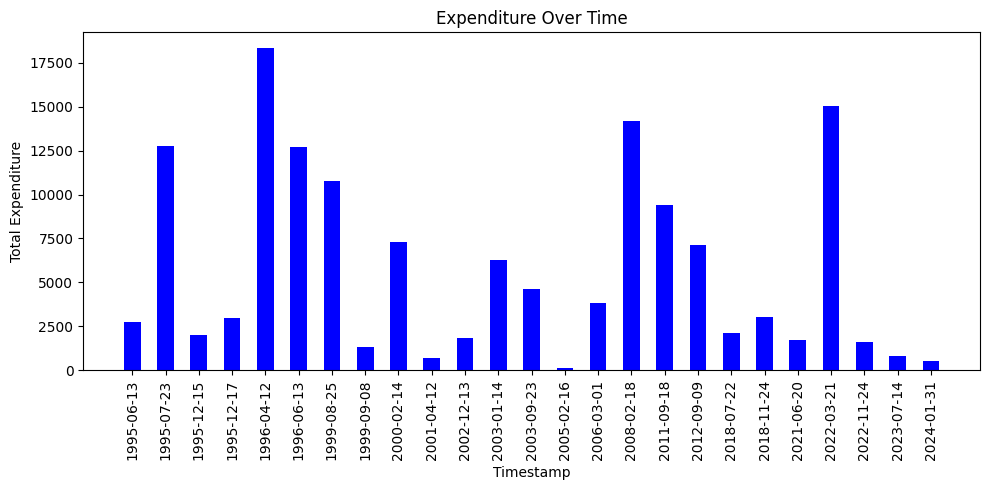

In [0]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("SalesDataDisplay").getOrCreate()

json_file_path = "dbfs:/FileStore/sales_data/sample_sales.json"
delta_table_path = "dbfs:/FileStore/sales_data/delta_table"

df = spark.read.json(json_file_path)
df.write.format("delta").mode("overwrite").save(delta_table_path)

df = spark.read.format("delta").load(delta_table_path)

data = df.select("timestamp", "quantity", "price", "category").collect()

if data:
    timestamps = [row.timestamp for row in data]  
    total_expenditure = [row.quantity * row.price for row in data]

    bef_sort_data = list(zip(timestamps, total_expenditure))
    sorted_data = sorted(bef_sort_data, key=lambda x: x[0])
    sorted_timestamps, sorted_total_expenditure = zip(*sorted_data)

    plt.figure(figsize=(10, 5))
    # plt.plot(timestamps, quantities, marker='o', linestyle='-', color='b')
    # plt.bar(timestamps, quantities, color='b', width=0.5)
    plt.bar(sorted_timestamps, sorted_total_expenditure, color='b', width=0.5)
    plt.title("Expenditure Over Time")
    plt.xlabel("Timestamp")
    plt.ylabel("Total Expenditure")
    plt.xticks(rotation=90)  
    plt.tight_layout()  
    # plt.grid()  
    plt.show()
else:
    print("No data available in the DataFrame.")


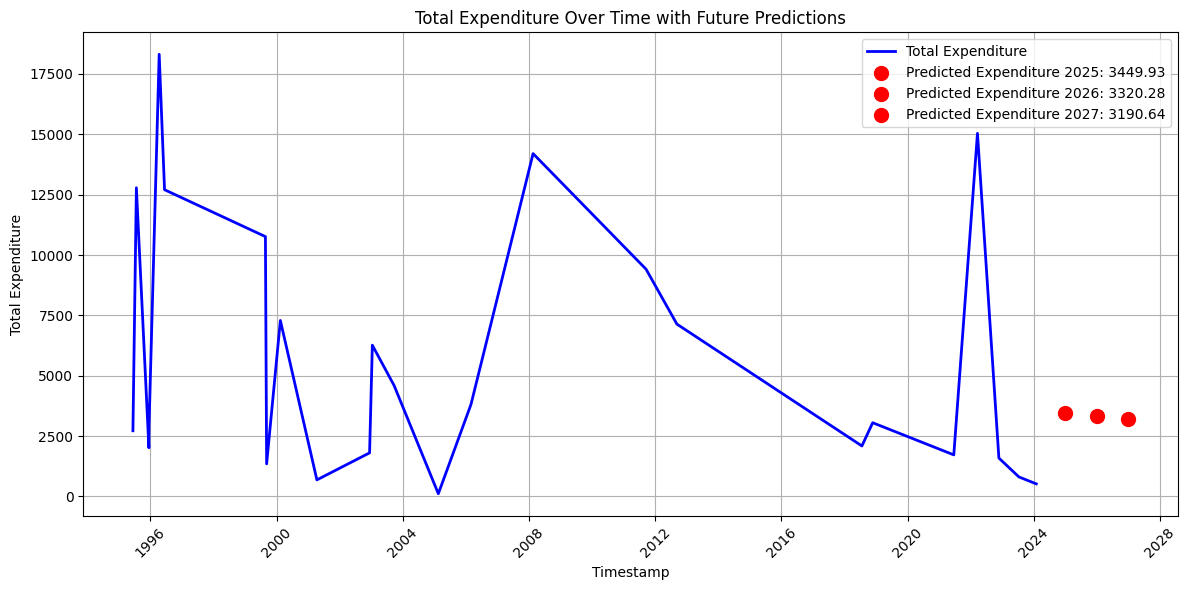

In [0]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from datetime import datetime, timedelta

spark = SparkSession.builder.appName("SalesDataDisplay").getOrCreate()


json_file_path = "dbfs:/FileStore/sales_data/sample_sales.json"
delta_table_path = "dbfs:/FileStore/sales_data/delta_table"

df = spark.read.json(json_file_path)
df.write.format("delta").mode("overwrite").save(delta_table_path)

df = spark.read.format("delta").load(delta_table_path)

data = df.select("timestamp", "quantity", "price", "category").collect()

if data:
    timestamps = [row.timestamp for row in data] 
    total_expenditure = [row.quantity * row.price for row in data]

    df_expenditure = pd.DataFrame({
        'timestamp': pd.to_datetime(timestamps),
        'total_expenditure': total_expenditure
    })

    df_expenditure = df_expenditure.groupby('timestamp').sum().reset_index()

    df_expenditure.sort_values('timestamp', inplace=True)

    df_expenditure['date_ordinal'] = df_expenditure['timestamp'].apply(lambda x: x.toordinal())
    X = df_expenditure['date_ordinal'].values.reshape(-1, 1)
    y = df_expenditure['total_expenditure'].values

    model = LinearRegression()
    model.fit(X, y)

    future_dates = []
    future_expenditures = []
    
    for year in [2025, 2026, 2027]:
        future_date = pd.to_datetime(f'{year}-01-01')
        future_dates.append(future_date)
        future_expenditure = model.predict(np.array([[future_date.toordinal()]]))[0]
        future_expenditures.append(future_expenditure)

    plt.figure(figsize=(12, 6))

    plt.plot(df_expenditure['timestamp'], df_expenditure['total_expenditure'], color='b', label='Total Expenditure', linewidth=2)

    for year, expenditure in zip([2025, 2026, 2027], future_expenditures):
        plt.scatter(pd.to_datetime(f'{year}-01-01'), expenditure, color='r', s=100, label=f'Predicted Expenditure {year}: {expenditure:.2f}')

    plt.title("Total Expenditure Over Time with Future Predictions")
    plt.xlabel("Timestamp")
    plt.ylabel("Total Expenditure")
    plt.xticks(rotation=45) 
    plt.tight_layout()
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("No data available in the DataFrame.")
